# SpikeInterface test and implementation workflow


### Extracting Variables

In [3]:
from pathlib import Path

# Extractors from SpikeInterface
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
from spikeinterface import concatenate_recordings
# from spikeinterface.sorters.kilosort3 import Kilosort3Sorter


# Neo class and methods for openephys data extraction/exploration
from neo.rawio.openephysbinaryrawio import explore_folder
# Kilosort3Sorter.set_kilosort3_path('/home/MRC.OX.AC.UK/phar0732/Documents/GitHub/Kilosort')



In [4]:
## Folder to Analyze
rec_directory = Path('/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/neuropixels/JC318L_2022-12-15_14-55-31_dual') 

# Explore folder with neo utilities for openephys
folder_structure, all_streams, nb_block, nb_segment_per_block,\
    possible_experiment_names = explore_folder(rec_directory)

print(f'Nb of Experiments (blocks): {nb_block}\nNb of segments per block: {nb_segment_per_block}\nDefault exp name: {possible_experiment_names}')

Nb of Experiments (blocks): 1
Nb of segments per block: {0: 3}
Default exp name: ['experiment1']


Resulting folder structure for openephys recordings is quite complex and results in heavily nested dictionary:

In [5]:
folder_structure['Record Node 101']['experiments'][1]['recordings'][3]['streams']['continuous']['Record Node 101#Neuropix-PXI-100.ProbeA-AP']['raw_filename']

'/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/neuropixels/JC318L_2022-12-15_14-55-31_dual/Record Node 101/experiment1/recording3/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat'

In [6]:
folder_structure['Record Node 101']['experiments'][1]['recordings'][2]['streams']['continuous']['Record Node 101#Neuropix-PXI-100.ProbeA-AP']['t_start'] 

0.10264274666666667

In [7]:
output_path = '/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/neuropixels/JC318L_2022-12-15_14-55-31_dual/sorted/recording1/Record Node 101#Neuropix-PXI-100.ProbeA-AP/sorter_output'
import os
os.listdir(output_path)

['spike_templates.npy',
 'templates_ind.npy',
 'kilosort3_master.m',
 'channel_positions.npy',
 'params.py',
 'run_kilosort3.sh',
 'kilosort3.log',
 'cluster_Amplitude.tsv',
 'temp_wh.dat',
 'writeNPY.m',
 'whitening_mat.npy',
 'cluster_ContamPct.tsv',
 'whitening_mat_inv.npy',
 'amplitudes.npy',
 'spike_clusters.npy',
 'spike_times.npy',
 'constructNPYheader.m',
 'cluster_KSLabel.tsv',
 'templates.npy',
 'chanMap.mat',
 'similar_templates.npy',
 'cluster_group.tsv',
 'channel_map.npy',
 'ops.mat']

In [8]:
## Folder to Analyze
rec_directory = Path('/home/MRC.OX.AC.UK/phar0732/ettin/Data/Recordings/JC318L_2022-12-15_14-55-31_dual') 

# Explore folder with neo utilities for openephys
folder_structure, all_streams, nb_block, nb_segment_per_block,\
    possible_experiment_names = explore_folder(rec_directory)

print(f'Nb of Experiments (blocks): {nb_block}\nNb of segments per block: {nb_segment_per_block}\nDefault exp name: {possible_experiment_names}\n')



# List continuous streams names
continuous_streams = list(folder_structure['Record Node 101']['experiments'][1]['recordings'][1]['streams']['continuous'].keys())
# Only select action potentials streams
AP_streams = [AP_stream for AP_stream in continuous_streams if 'AP' in AP_stream]
print(f'Spike streams:{AP_streams}\n')

IndexError: list index out of range

In [44]:
folder_structure['Record Node 101']['experiments'][1]['recordings'][1]['streams']['continuous']['Record Node 101#Neuropix-PXI-100.ProbeA-AP'].keys()

dict_keys(['folder_name', 'sample_rate', 'source_processor_name', 'source_processor_id', 'stream_name', 'recorded_processor', 'recorded_processor_id', 'num_channels', 'channels', 'raw_filename', 'dtype', 'timestamp0', 't_start'])

In [60]:
from datetime import datetime, timedelta
import re
import os
import pandas as pd

def parse_openephys_folder(fn):
    m = re.split('_', fn)
    if m:
        animal_id = m[0]
        date_string = m[1]
        time_string = m[2]
        expt_datetime = datetime.strptime(date_string+'_'+time_string, "%Y-%m-%d_%H-%M-%S")
        
        return {'animal_id':animal_id,
                'foldername':fn, 
                'exp_datetime':expt_datetime}

def get_recordings_properties(ephys_base_path, fn):
    exp_dict = parse_openephys_folder(fn)

    # Explore folder with neo utilities for openephys
    folder_structure, all_streams, nb_block, nb_segment_per_block,\
        experiment_names = explore_folder(Path(ephys_base_path) / fn)


    # List continuous streams names
    continuous_streams = list(folder_structure['Record Node 101']['experiments'][1]['recordings'][1]['streams']['continuous'].keys())
    # Only select action potentials streams
    AP_streams = [AP_stream for AP_stream in continuous_streams if 'AP' in AP_stream]
    print(f'Nb of Experiments (blocks): {nb_block}\nNb of segments per block: {nb_segment_per_block}\nDefault exp name: {possible_experiment_names}\n')
    print(f'Spike streams:{AP_streams}\n')

    if len(experiment_names) > 1:
        raise NotImplementedError('More than one experiment in the open-ephys folder')
    
    recordings_properties = dict()

    for k in exp_dict.keys():
        recordings_properties[k] = list()

    recordings_properties['AP_stream'] = list()
    recordings_properties['AP_folder'] = list()
    recordings_properties['rec_nb'] = list()
    recordings_properties['tstart'] = list()
    recordings_properties['rec_start_datetime'] = list()
    recordings_properties['full_path'] = list()
    recordings_properties['nidaq_TTL_path'] = list()

    rec_keys = list(folder_structure['Record Node 101']['experiments'][1]['recordings'].keys())

    for idx, rec_nb in enumerate(rec_keys):

        for AP_stream in AP_streams:
            for k, v in exp_dict.items():
                recordings_properties[k].append(v)

            recordings_properties['AP_stream'].append(AP_stream)
            recordings_properties['AP_folder'].append(re.split('#',AP_stream)[1])

            recordings_properties['rec_nb'].append(rec_nb)
            recordings_properties['tstart'].append(
                folder_structure['Record Node 101']['experiments'][1]['recordings'][rec_nb]['streams']['continuous'][AP_streams[0]]['t_start']
            )
            recordings_properties['rec_start_datetime'].append(
                exp_dict['exp_datetime'] + timedelta(0,recordings_properties['tstart'][idx])
            )
            recordings_properties['full_path'].append(
                Path(ephys_base_path) / fn / 'Record Node 101' / experiment_names[0] / ('recording' + str(rec_nb)) / 'continuous' / recordings_properties['AP_folder'][idx]
            )

            recordings_properties['nidaq_TTL_path'].append(
                Path(ephys_base_path) / fn / 'Record Node 104' / experiment_names[0] / ('recording' + str(rec_nb)) / 'events' / 'NI-DAQmx-103.PXIe-6341' / 'TTL'
            )

    return pd.DataFrame(recordings_properties)

def get_ephys_rsync(recordings_properties: pd.DataFrame, rsync_ephys_chan_idx: int = 2):
    ...

In [29]:
ephys_base_path = '/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/_Other/test_folder_ephys'
open_ephys_folders = os.listdir(Path(ephys_base_path))

In [61]:
recordings_properties = get_recordings_properties(ephys_base_path, open_ephys_folders[-1])
os.listdir(recordings_properties.nidaq_TTL_path.iloc[0])

Nb of Experiments (blocks): 1
Nb of segments per block: {0: 3}
Default exp name: ['experiment1']

Spike streams:['Record Node 101#Neuropix-PXI-100.ProbeA-AP', 'Record Node 101#Neuropix-PXI-100.ProbeB-AP']



['full_words.npy', 'timestamps.npy', 'states.npy', 'sample_numbers.npy']

In [ ]:
def 

In [33]:
re.split('_',open_ephys_folders[-1])

['JC317L', '2023-03-07', '14-54-46', 'dual', 'reward', 'only']

In [16]:
folder_structure['Record Node 101']['experiments'][1]['recordings'][1]['streams']['continuous']['Record Node 101#Neuropix-PXI-100.ProbeA-AP']['t_start']

2769.8652

In [19]:
folder_structure['Record Node 101']['experiments'][1]['settings_file']

PosixPath('/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/neuropixels/JC318L_2022-12-15_14-55-31_dual/Record Node 101/settings.xml')

In [13]:
datetime.fromtimestamp(folder_structure['Record Node 101']['experiments'][1]['recordings'][1]['streams']['continuous']['Record Node 101#Neuropix-PXI-100.ProbeA-AP']['timestamp0'])

datetime.datetime(1972, 8, 19, 19, 12, 36)

## Sorting

- all sorters must be installed separately, see https://spikeinterface.readthedocs.io/en/latest/install_sorters.html

### Kilosort3
- Kilosort3 is installed on matlab, it requires to previously sort out NVIDIA drivers, and properly setup CUDA (when GPU allows), see https://github.com/MouseLand/Kilosort
- It should be tested on Matlab separately to see if everything works correctly
- then, in the conda environment, you need to set the environement variables indicating the location of the install:
  - e.g:
  ```
  conda activate trialexp
  conda env config vars set KILOSORT3_PATH="C:\Users\phar0732\OneDrive - Nexus365\Documents\GitHub\Kilosort" 
  ```
- Alternatively to the environment variable, you can use the following command in the notebook or else:  
  ```
  Kilosort3Sorter.set_kilosort3_path('/home/MRC.OX.AC.UK/phar0732/Documents/GitHub/Kilosort')
  ```



The following cell highlight how to get default params for one specific sorter and how to change them to pass as argument to the sorter.

In [5]:
sorter_name = 'kilosort3'
# Print parameters names and default values for the selected sorter
print(f'default params for selected sorter:\n{ss.get_default_sorter_params(sorter_name)}\n')

# Kilosort3
sorter_specific_params = {
    'n_jobs': 24, 
    'total_memory': 512000000000, 
    'chunk_size': None, 
    'chunk_memory': 12800000000,
    'chunk_duration': '30s', 
    'progress_bar': True}

Here we loop among the streams (High-pass filtered files for the two probes), and the recordings (potentially baseline + experiment, or task1/task2...)

In [ ]:


for AP_stream in AP_streams:
    recordings = se.read_openephys(rec_directory, block_index=0, stream_name=AP_stream)
    rec_list = []
    # loop over all segments
    for i in [1,2]: #range(recordings.get_num_segments()-1): #first segement useless
        # rec_list.append(recordings._select_segments(i))
    
        # concatenated_folder = Path(rec_directory) / 'concatenated' / AP_stream
        sorted_folder = Path(rec_directory) / 'sorted' / f'recording{i}' / AP_stream
        temp_folder = Path(rec_directory) / 'temp' / f'recording{i}' / AP_stream

        # saved_rec = recordings._select_segments(i).save(folder= temp_folder, n_jobs = 24, chunk_size = 300000)

    # concatenate all segments to perform sorting on the full recording day (baseline + different tasks)
    # concat_recordings = concatenate_recordings(rec_list)
    # concat_recordings.save()
    # concat_recordings.save(folder=concatenated_folder, n_jobs=32, total_memory="32G")
        print(f'sorting dir: {rec_directory}\nStream: {AP_stream}\nRecording #{i}\nSorted in: {sorted_folder}')
        
        sorting = ss.run_sorter(
            sorter_name = sorter_name,
            recording = saved_rec, 
            output_folder = sorted_folder,
            remove_existing_folder = True, 
            delete_output_folder = False, 
            verbose = True,
            docker_image=False,
            **sorter_specific_params)
        

In [21]:
events = se.read_openephys_event(rec_directory)
events.get_num_segments()
events.get_num_channels()
print(rec_directory, '\n', events.channel_ids)
events.get_event_times(channel_id = events.channel_ids[3], segment_index=2)

/home/MRC.OX.AC.UK/phar0732/ettin/Data/Recordings/JC318L_2022-12-15_14-55-31_dual 
 ['Messages' 'Event Translator output' 'Messages' 'Event Translator output']


array([], dtype=float64)

Recovering Ephys timestamps of Rsync signals from PyControl

In [ ]:
import numpy as np

rsync_ephys_chan_idx = 2

ev_folder = Path(rec_directory , 'Record Node 104', 'experiment1', 'recording2', \
    'events', 'NI-DAQmx-103.PXIe-6341','TTL')
ev_array = np.load(Path(ev_folder, 'states.npy'))
ts_array = np.load(Path(ev_folder, 'timestamps.npy'))
# ev_array.
# unique_val_count = {val:np.count_nonzero(ev_array == val) for val in set(ev_array)}
# unique_val_count
rsync_ephys_ts = ts_array[ev_array == rsync_ephys_chan_idx]

In [ ]:
import os 

sessions_folder = '/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/by_sessions/{task}')


### Concatenate / Append recordings

- Some sorters, at least Kilosort3, does not support sorting on separate recordings, like baseline and behaviour, one task then another, or simply a failed attempt to launch the task (yet ephys has been recorded due to the pycontrol triggering of ephys)
- These recordings must be concatenated (see: https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_5_append_concatenate_segments.html#append-and-or-concatenate-segments)

In [ ]:
from spikeinterface import append_recordings, concatenate_recordings
rec_list = []
for i in range(recording_OE.get_num_segments()):
    rec_list.append(recording_OE._select_segments(i))

concat_recordings = concatenate_recordings(rec_list)


In [ ]:
Path(rec_directory) / 'sorted' / stream_name

WindowsPath('T:/Data/Recordings/JC318L_2022-12-15_14-55-31_dual/sorted/Record Node 101#Neuropix-PXI-100.ProbeA-AP')

In [ ]:
output_folder = Path(rec_directory) / 'sorted' / stream_name
concat_recordings.save(folder=output_folder, n_jobs=32, total_memory="48G")

### API ref to run sorters
```
spikeinterface.sorters.run_sorter(sorter_name: str, recording: BaseRecording, output_folder: Optional[str] = None, remove_existing_folder: bool = True, delete_output_folder: bool = False, verbose: bool = False, raise_error: bool = True, docker_image: Optional[Union[bool, str]] = False, singularity_image: Optional[Union[bool, str]] = False, with_output: bool = True, **sorter_params)
```

### Sorting variables

In [ ]:
## Sorting Variables


sorter_name = 'kilosort3'
recording = concat_recordings
output_folder = Path(rec_directory) / 'sorted' / stream_name
# remove_existing_folder: bool = True, 
# delete_output_folder: bool = False, 
verbose = True 
# raise_error: bool = True, 
# docker_image: Optional[Union[bool, str]] = False, 
# singularity_image: Optional[Union[bool, str]] = False, 
# with_output: bool = True, 

### Run the sorting

In [ ]:
from spikeinterface import sorters
sorting = sorters.run_sorter(
    sorter_name = sorter_name,
    recording = recording, 
    output_folder = output_folder,
    # remove_existing_folder: bool = True, 
    # delete_output_folder: bool = False, 
    verbose = verbose)
    # raise_error: bool = True, 
    # docker_image: Optional[Union[bool, str]] = False, 
    # singularity_image: Optional[Union[bool, str]] = False, 
    # with_output: bool = True, 
    # **sorter_params)

    # ValueError: This sorter kilosort3 do not handle multi segment, use si.concatenate_recordings(...)




Probe - 384ch - 1shanks


(<matplotlib.collections.PolyCollection at 0x1c16051b1f0>,
 <matplotlib.collections.PolyCollection at 0x1c1605bcc10>)

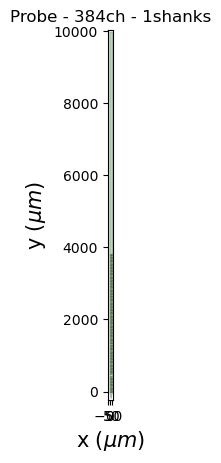

In [ ]:
probe = recording.get_probe()
print(probe)

from probeinterface.plotting import plot_probe

plot_probe(probe)

In [ ]:
import spikeinterface as si
import spikeinterface.extractors as se
from spikeinterface.postprocessing import get_template_extremum_channel, compute_principal_components
print(recording)
print(sorting)
# test_rec.continuous[0].samples

ImportError: Numba needs NumPy 1.22 or less